In [ ]:
https://deep-learning-study.tistory.com/368

In [11]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import subprocess as sp
from PIL import Image

from datetime import datetime

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
DEVICE = "cuda"

In [12]:
# parameters
RANDOM_SEED = 42 # random seed를 42로 쓰는 건 관습이라고 함 (은하수를 여행하는 히치하이커를 위한 안내서)
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [13]:
def get_accuracy(model, data_loader, device):
    '''
    전체 data_loader에 대한 예측의 정확도를 계산하는 함수
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            print("n::",n)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    training과 validation loss를 시각화하는 함수
    '''
    
    # plot style을 seaborn으로 설정
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # plot style을 기본값으로 설정
    plt.style.use('default')

In [14]:
# training data에 사용되는 helper 함수

def train(train_loader, model, criterion, optimizer, device):
    '''
    training loop의 training 단계에 대한 함수
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # 순전파
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # 역전파
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [15]:
# validation data에 사용되는 함수 (역전파X)

def validate(valid_loader, model, criterion, device):
    '''
    training loop의 validation 단계에 대한 함수
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # 순전파와 손실 기록하기
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [16]:
# training loop 정의

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    전체 training loop를 정의하는 함수
    '''
    
    # metrics를 저장하기 위한 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # model 학습하기
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

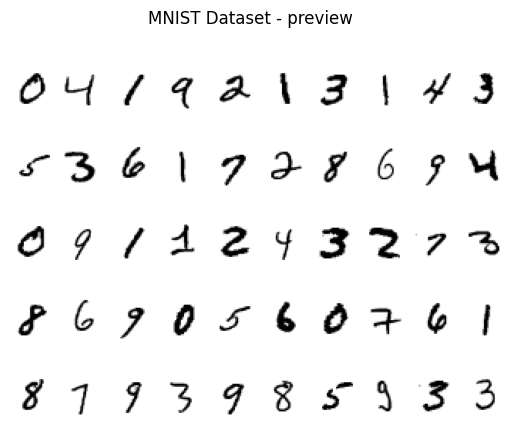

In [17]:
##########################
### MNIST DATASET
##########################

resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

# Note transforms.ToTensor() scales input images
# to 0-1 range

# data set 다운받고 생성하기
train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=resize_transform,
                               download=True)

valid_dataset = datasets.MNIST(root='./data', 
                              train=False, 
                              transform=resize_transform)

# data loader 정의하기
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# 불러온 MNIST data 확인하기
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [18]:
##########################
### LeNet-5 구조 정의 - default (배치 정규화)
### 활성화 함수: tanh, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        # Sequential: layer을 순서대로 적용
        self.feature_extractor = nn.Sequential(          
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [46]:
##########################
### LeNet-5 구조 정의 - 변형1(논문 그대로 - 풀링계층을 서브샘플링계층으로, C3 layer 변경)
### 활성화 함수: tanh, 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

import torch
import torch.nn as nn
import torch.nn.functional as F

class SubsamplingLayer(nn.Module):
    def __init__(self, in_channels):
        super(SubsamplingLayer, self).__init__()
        self.in_channels = in_channels
        self.weight = nn.Parameter(torch.Tensor(in_channels))
        self.bias = nn.Parameter(torch.Tensor(in_channels))
        self.sigmoid = nn.Sigmoid()
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.ones_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        out = F.avg_pool2d(x, kernel_size=2) * 4  # Sum over the 2x2 region
        out = out * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)
        return self.sigmoid(out)

    
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # C3 테이블 연결에 따른 컨볼루션 정의
        self.convs = nn.ModuleList()
        self.connections = [
            [0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 0], [5, 0, 1],
            [0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 0], [4, 5, 0, 1], [5, 0, 1, 2],
            [0, 1, 3, 4], [1, 2, 4, 5], [0, 2, 3, 5], [0, 1, 2, 3, 4, 5]
        ]
        
        for conn in self.connections:
            self.convs.append(nn.Conv2d(len(conn), 1, kernel_size, stride, padding))
        
    def forward(self, x):
        out = []
        for conv, conn in zip(self.convs, self.connections):
            out.append(conv(x[:, conn, :, :]))
        return torch.cat(out, dim=1)

    
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            SubsamplingLayer(in_channels=6),
            CustomConv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            SubsamplingLayer(in_channels=16),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs    

In [56]:
##########################
### LeNet-5 구조 정의 - 변형2(ReLU 사용)
### 활성화 함수: ReLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [66]:
##########################
### LeNet-5 구조 정의 - 변형3(SiLU 사용)
### 활성화 함수: SiLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.SiLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.SiLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [76]:
##########################
### LeNet-5 구조 정의 - 변형4-1(최대풀링 사용)
### 활성화 함수: ReLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [86]:
##########################
### LeNet-5 구조 정의 - 변형4-2(최소풀링 사용)
### 활성화 함수: ReLU, 출력층 활성화 함수: softmax, 최적화: Adam, 손실함수: 교차엔트로피
##########################

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.BatchNorm2d(120),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [19]:
##########################
### model, optimizer, loss function 설정
##########################

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(model)


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Tanh()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [20]:
##########################
### 신경망 학습
##########################

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, 
                                    valid_loader, N_EPOCHS, DEVICE)

n:: 32
n:: 64
n:: 96
n:: 128
n:: 160
n:: 192
n:: 224
n:: 256
n:: 288
n:: 320
n:: 352
n:: 384
n:: 416
n:: 448
n:: 480
n:: 512
n:: 544
n:: 576
n:: 608
n:: 640
n:: 672
n:: 704
n:: 736
n:: 768
n:: 800
n:: 832
n:: 864
n:: 896
n:: 928
n:: 960
n:: 992
n:: 1024
n:: 1056
n:: 1088
n:: 1120
n:: 1152
n:: 1184
n:: 1216
n:: 1248
n:: 1280
n:: 1312
n:: 1344
n:: 1376
n:: 1408
n:: 1440
n:: 1472
n:: 1504
n:: 1536
n:: 1568
n:: 1600
n:: 1632
n:: 1664
n:: 1696
n:: 1728
n:: 1760
n:: 1792
n:: 1824
n:: 1856
n:: 1888
n:: 1920
n:: 1952
n:: 1984
n:: 2016
n:: 2048
n:: 2080
n:: 2112
n:: 2144
n:: 2176
n:: 2208
n:: 2240
n:: 2272
n:: 2304
n:: 2336
n:: 2368
n:: 2400
n:: 2432
n:: 2464
n:: 2496
n:: 2528
n:: 2560
n:: 2592
n:: 2624
n:: 2656
n:: 2688
n:: 2720
n:: 2752
n:: 2784
n:: 2816
n:: 2848
n:: 2880
n:: 2912
n:: 2944
n:: 2976
n:: 3008
n:: 3040
n:: 3072
n:: 3104
n:: 3136
n:: 3168
n:: 3200
n:: 3232
n:: 3264
n:: 3296
n:: 3328
n:: 3360
n:: 3392
n:: 3424
n:: 3456
n:: 3488
n:: 3520
n:: 3552
n:: 3584
n:: 3616
n:: 3648
n:: 3680

n:: 27552
n:: 27584
n:: 27616
n:: 27648
n:: 27680
n:: 27712
n:: 27744
n:: 27776
n:: 27808
n:: 27840
n:: 27872
n:: 27904
n:: 27936
n:: 27968
n:: 28000
n:: 28032
n:: 28064
n:: 28096
n:: 28128
n:: 28160
n:: 28192
n:: 28224
n:: 28256
n:: 28288
n:: 28320
n:: 28352
n:: 28384
n:: 28416
n:: 28448
n:: 28480
n:: 28512
n:: 28544
n:: 28576
n:: 28608
n:: 28640
n:: 28672
n:: 28704
n:: 28736
n:: 28768
n:: 28800
n:: 28832
n:: 28864
n:: 28896
n:: 28928
n:: 28960
n:: 28992
n:: 29024
n:: 29056
n:: 29088
n:: 29120
n:: 29152
n:: 29184
n:: 29216
n:: 29248
n:: 29280
n:: 29312
n:: 29344
n:: 29376
n:: 29408
n:: 29440
n:: 29472
n:: 29504
n:: 29536
n:: 29568
n:: 29600
n:: 29632
n:: 29664
n:: 29696
n:: 29728
n:: 29760
n:: 29792
n:: 29824
n:: 29856
n:: 29888
n:: 29920
n:: 29952
n:: 29984
n:: 30016
n:: 30048
n:: 30080
n:: 30112
n:: 30144
n:: 30176
n:: 30208
n:: 30240
n:: 30272
n:: 30304
n:: 30336
n:: 30368
n:: 30400
n:: 30432
n:: 30464
n:: 30496
n:: 30528
n:: 30560
n:: 30592
n:: 30624
n:: 30656
n:: 30688
n:: 30720


n:: 53952
n:: 53984
n:: 54016
n:: 54048
n:: 54080
n:: 54112
n:: 54144
n:: 54176
n:: 54208
n:: 54240
n:: 54272
n:: 54304
n:: 54336
n:: 54368
n:: 54400
n:: 54432
n:: 54464
n:: 54496
n:: 54528
n:: 54560
n:: 54592
n:: 54624
n:: 54656
n:: 54688
n:: 54720
n:: 54752
n:: 54784
n:: 54816
n:: 54848
n:: 54880
n:: 54912
n:: 54944
n:: 54976
n:: 55008
n:: 55040
n:: 55072
n:: 55104
n:: 55136
n:: 55168
n:: 55200
n:: 55232
n:: 55264
n:: 55296
n:: 55328
n:: 55360
n:: 55392
n:: 55424
n:: 55456
n:: 55488
n:: 55520
n:: 55552
n:: 55584
n:: 55616
n:: 55648
n:: 55680
n:: 55712
n:: 55744
n:: 55776
n:: 55808
n:: 55840
n:: 55872
n:: 55904
n:: 55936
n:: 55968
n:: 56000
n:: 56032
n:: 56064
n:: 56096
n:: 56128
n:: 56160
n:: 56192
n:: 56224
n:: 56256
n:: 56288
n:: 56320
n:: 56352
n:: 56384
n:: 56416
n:: 56448
n:: 56480
n:: 56512
n:: 56544
n:: 56576
n:: 56608
n:: 56640
n:: 56672
n:: 56704
n:: 56736
n:: 56768
n:: 56800
n:: 56832
n:: 56864
n:: 56896
n:: 56928
n:: 56960
n:: 56992
n:: 57024
n:: 57056
n:: 57088
n:: 57120


n:: 12480
n:: 12512
n:: 12544
n:: 12576
n:: 12608
n:: 12640
n:: 12672
n:: 12704
n:: 12736
n:: 12768
n:: 12800
n:: 12832
n:: 12864
n:: 12896
n:: 12928
n:: 12960
n:: 12992
n:: 13024
n:: 13056
n:: 13088
n:: 13120
n:: 13152
n:: 13184
n:: 13216
n:: 13248
n:: 13280
n:: 13312
n:: 13344
n:: 13376
n:: 13408
n:: 13440
n:: 13472
n:: 13504
n:: 13536
n:: 13568
n:: 13600
n:: 13632
n:: 13664
n:: 13696
n:: 13728
n:: 13760
n:: 13792
n:: 13824
n:: 13856
n:: 13888
n:: 13920
n:: 13952
n:: 13984
n:: 14016
n:: 14048
n:: 14080
n:: 14112
n:: 14144
n:: 14176
n:: 14208
n:: 14240
n:: 14272
n:: 14304
n:: 14336
n:: 14368
n:: 14400
n:: 14432
n:: 14464
n:: 14496
n:: 14528
n:: 14560
n:: 14592
n:: 14624
n:: 14656
n:: 14688
n:: 14720
n:: 14752
n:: 14784
n:: 14816
n:: 14848
n:: 14880
n:: 14912
n:: 14944
n:: 14976
n:: 15008
n:: 15040
n:: 15072
n:: 15104
n:: 15136
n:: 15168
n:: 15200
n:: 15232
n:: 15264
n:: 15296
n:: 15328
n:: 15360
n:: 15392
n:: 15424
n:: 15456
n:: 15488
n:: 15520
n:: 15552
n:: 15584
n:: 15616
n:: 15648


n:: 38912
n:: 38944
n:: 38976
n:: 39008
n:: 39040
n:: 39072
n:: 39104
n:: 39136
n:: 39168
n:: 39200
n:: 39232
n:: 39264
n:: 39296
n:: 39328
n:: 39360
n:: 39392
n:: 39424
n:: 39456
n:: 39488
n:: 39520
n:: 39552
n:: 39584
n:: 39616
n:: 39648
n:: 39680
n:: 39712
n:: 39744
n:: 39776
n:: 39808
n:: 39840
n:: 39872
n:: 39904
n:: 39936
n:: 39968
n:: 40000
n:: 40032
n:: 40064
n:: 40096
n:: 40128
n:: 40160
n:: 40192
n:: 40224
n:: 40256
n:: 40288
n:: 40320
n:: 40352
n:: 40384
n:: 40416
n:: 40448
n:: 40480
n:: 40512
n:: 40544
n:: 40576
n:: 40608
n:: 40640
n:: 40672
n:: 40704
n:: 40736
n:: 40768
n:: 40800
n:: 40832
n:: 40864
n:: 40896
n:: 40928
n:: 40960
n:: 40992
n:: 41024
n:: 41056
n:: 41088
n:: 41120
n:: 41152
n:: 41184
n:: 41216
n:: 41248
n:: 41280
n:: 41312
n:: 41344
n:: 41376
n:: 41408
n:: 41440
n:: 41472
n:: 41504
n:: 41536
n:: 41568
n:: 41600
n:: 41632
n:: 41664
n:: 41696
n:: 41728
n:: 41760
n:: 41792
n:: 41824
n:: 41856
n:: 41888
n:: 41920
n:: 41952
n:: 41984
n:: 42016
n:: 42048
n:: 42080


n:: 5920
n:: 5952
n:: 5984
n:: 6016
n:: 6048
n:: 6080
n:: 6112
n:: 6144
n:: 6176
n:: 6208
n:: 6240
n:: 6272
n:: 6304
n:: 6336
n:: 6368
n:: 6400
n:: 6432
n:: 6464
n:: 6496
n:: 6528
n:: 6560
n:: 6592
n:: 6624
n:: 6656
n:: 6688
n:: 6720
n:: 6752
n:: 6784
n:: 6816
n:: 6848
n:: 6880
n:: 6912
n:: 6944
n:: 6976
n:: 7008
n:: 7040
n:: 7072
n:: 7104
n:: 7136
n:: 7168
n:: 7200
n:: 7232
n:: 7264
n:: 7296
n:: 7328
n:: 7360
n:: 7392
n:: 7424
n:: 7456
n:: 7488
n:: 7520
n:: 7552
n:: 7584
n:: 7616
n:: 7648
n:: 7680
n:: 7712
n:: 7744
n:: 7776
n:: 7808
n:: 7840
n:: 7872
n:: 7904
n:: 7936
n:: 7968
n:: 8000
n:: 8032
n:: 8064
n:: 8096
n:: 8128
n:: 8160
n:: 8192
n:: 8224
n:: 8256
n:: 8288
n:: 8320
n:: 8352
n:: 8384
n:: 8416
n:: 8448
n:: 8480
n:: 8512
n:: 8544
n:: 8576
n:: 8608
n:: 8640
n:: 8672
n:: 8704
n:: 8736
n:: 8768
n:: 8800
n:: 8832
n:: 8864
n:: 8896
n:: 8928
n:: 8960
n:: 8992
n:: 9024
n:: 9056
n:: 9088
n:: 9120
n:: 9152
n:: 9184
n:: 9216
n:: 9248
n:: 9280
n:: 9312
n:: 9344
n:: 9376
n:: 9408
n:: 9440
n

n:: 23360
n:: 23392
n:: 23424
n:: 23456
n:: 23488
n:: 23520
n:: 23552
n:: 23584
n:: 23616
n:: 23648
n:: 23680
n:: 23712
n:: 23744
n:: 23776
n:: 23808
n:: 23840
n:: 23872
n:: 23904
n:: 23936
n:: 23968
n:: 24000
n:: 24032
n:: 24064
n:: 24096
n:: 24128
n:: 24160
n:: 24192
n:: 24224
n:: 24256
n:: 24288
n:: 24320
n:: 24352
n:: 24384
n:: 24416
n:: 24448
n:: 24480
n:: 24512
n:: 24544
n:: 24576
n:: 24608
n:: 24640
n:: 24672
n:: 24704
n:: 24736
n:: 24768
n:: 24800
n:: 24832
n:: 24864
n:: 24896
n:: 24928
n:: 24960
n:: 24992
n:: 25024
n:: 25056
n:: 25088
n:: 25120
n:: 25152
n:: 25184
n:: 25216
n:: 25248
n:: 25280
n:: 25312
n:: 25344
n:: 25376
n:: 25408
n:: 25440
n:: 25472
n:: 25504
n:: 25536
n:: 25568
n:: 25600
n:: 25632
n:: 25664
n:: 25696
n:: 25728
n:: 25760
n:: 25792
n:: 25824
n:: 25856
n:: 25888
n:: 25920
n:: 25952
n:: 25984
n:: 26016
n:: 26048
n:: 26080
n:: 26112
n:: 26144
n:: 26176
n:: 26208
n:: 26240
n:: 26272
n:: 26304
n:: 26336
n:: 26368
n:: 26400
n:: 26432
n:: 26464
n:: 26496
n:: 26528


n:: 50144
n:: 50176
n:: 50208
n:: 50240
n:: 50272
n:: 50304
n:: 50336
n:: 50368
n:: 50400
n:: 50432
n:: 50464
n:: 50496
n:: 50528
n:: 50560
n:: 50592
n:: 50624
n:: 50656
n:: 50688
n:: 50720
n:: 50752
n:: 50784
n:: 50816
n:: 50848
n:: 50880
n:: 50912
n:: 50944
n:: 50976
n:: 51008
n:: 51040
n:: 51072
n:: 51104
n:: 51136
n:: 51168
n:: 51200
n:: 51232
n:: 51264
n:: 51296
n:: 51328
n:: 51360
n:: 51392
n:: 51424
n:: 51456
n:: 51488
n:: 51520
n:: 51552
n:: 51584
n:: 51616
n:: 51648
n:: 51680
n:: 51712
n:: 51744
n:: 51776
n:: 51808
n:: 51840
n:: 51872
n:: 51904
n:: 51936
n:: 51968
n:: 52000
n:: 52032
n:: 52064
n:: 52096
n:: 52128
n:: 52160
n:: 52192
n:: 52224
n:: 52256
n:: 52288
n:: 52320
n:: 52352
n:: 52384
n:: 52416
n:: 52448
n:: 52480
n:: 52512
n:: 52544
n:: 52576
n:: 52608
n:: 52640
n:: 52672
n:: 52704
n:: 52736
n:: 52768
n:: 52800
n:: 52832
n:: 52864
n:: 52896
n:: 52928
n:: 52960
n:: 52992
n:: 53024
n:: 53056
n:: 53088
n:: 53120
n:: 53152
n:: 53184
n:: 53216
n:: 53248
n:: 53280
n:: 53312


KeyboardInterrupt: 